# Basic Ray Tracing

---

## References

- [Introduction to Ray Tracing: a Simple Method for Creating 3D Images by Scratchapixel 2.0](https://www.scratchapixel.com/lessons/3d-basic-rendering/introduction-to-ray-tracing/implementing-the-raytracing-algorithm)
- [Computer Graphics from scratch by Gabriel Gambetta](https://www.gabrielgambetta.com/computer-graphics-from-scratch/basic-ray-tracing.html)
- [Ray Tracing: Graphics for the Masses
by Paul Rademacher](http://wwwx.cs.unc.edu/~rademach/xroads-RT/RTarticle.html)

In [1]:
%%capture
!pip install pillow --quiet

In [2]:
from qmcpy import *
from numpy import *
from time import time
from PIL import Image
from matplotlib import pyplot
from threading import Thread
%matplotlib inline

In [3]:
# constants
EPS = 1e-8 # numerical precision error tolerance
norm = lambda v: sqrt(dot(v,v))
e = array([0,0,0],dtype=float) # eye location at the orgin

In [4]:
class Camera(object):
    """ An object to render the scene. """
    def __init__(self, ax, scene, px=8, parallel_x_blocks=2, parallel_y_blocks=2, image_angle=90, image_dist=1):
        """
        Args:
            ax (axes): matplotlib ax to plot image on
            scene (int): object with scene.render_px(p) method. See examples later in the notebook.
            px (int): number of pixels in height and width. 
                Resolution = px*px.
            parallel_x_blocks (int): number of cuts along the x axis in which to make parallel.
            parallel_y_blocks (int): number of cuts along the y axis in which to make parallel. 
                parallel_x/y_blocks must be divisors of px. 
                Number of threads = parallel_y_blocks * parallel_x_blocks. 
        """
        self.ax = ax
        self.scene = scene
        self.px = px
        self.fl = image_dist # distance from eye to image
        self.i_hw = tan(image_angle/2)*self.fl # half width of the image
        self.px_hw = self.i_hw/px # half width of a pixel
        # set parallelization constants
        self.p_xb = parallel_x_blocks; self.p_yb = parallel_y_blocks
        bs_x = px/self.p_xb; bs_y = px/self.p_yb # block size for x,y
        if bs_x%1!=0 or bs_y%1!=0: raise Exception('parallel_x/y_blocks must divide px')
        self.bs_x = int(bs_x); self.bs_y = int(bs_y)
    def render(self):
        """ Render the image. """
        t0 = time() # start a timer
        img = Image.new('RGB',(self.px,self.px),(0,0,0))
        if self.p_xb==1 and self.p_yb==1:
            # use non-parallel processing (helpful for debugging)
            self.block_render(img,0,self.px,0,self.px)
        else:
            # parallel processing
            threads = [None]*(self.p_xb*self.p_yb)
            i_t = 0 # thread index
            for xb in range(0,self.px,self.bs_x):
                for yb in range(0,self.px,self.bs_y):
                    threads[i_t] = Thread(target=self.block_render, args=(img,xb,xb+self.bs_x,yb,yb+self.bs_y))
                    threads[i_t].start() # start threads
                    i_t += 1
            for i in range(len(threads)): threads[i].join() # wait for all threads to complete
        self.ax.axis('off')
        self.ax.imshow(asarray(img))
        print('Render took %.1f seconds'%(time()-t0))
    def block_render(self, img, px_x_start, px_x_end, px_y_start, px_y_end):
        """
        Render a block of the image. 
        
        Args:
            img (PIL.Image): the image to color pixels of. 
            px_x_start (int): x index of pixel to start rendering at. 
            px_x_end (int): x index of pixel to end rendering at. 
            px_y_start (int): y index of pixel to start rendering at. 
            px_y_end (int): y index of pixel to start rendering at.
        """
        for p_x in range(px_x_start,px_x_end):
            for p_y in range(px_y_start,px_y_end):
                p = array([-self.i_hw+2*self.i_hw*p_x/self.px,-self.i_hw+2*self.i_hw*p_y/self.px,self.fl])
                color = self.scene.render_px(p)
                img.putpixel((p_x,self.px-p_y-1),color)    

In [5]:
class Plane(object):
    def __init__(self, norm_axis, position, color):
        """
        Args:
            norm_axis (str): either 'x', 'y', or 'z'.
            position (str): constant position of plane along the norm_axis.
            color (tuple): length 3 tuple of rgb values.
        """
        dim_dict = {'x':0,'y':1,'z':2}
        self.d = dim_dict[norm_axis]
        self.pos = position # self.norm_axis coordinate of the floor 
        self.color = color
    def hit(self, o, u):
        """
        Test if the beam o+tu hits the plane.
        
        Args:
            o (ndarray): length 3 origin point.
            u (ndarray): length 3 unit vector.
        
        Returns:
            tuple: 
                - hit (bool): was an object hit?
                - hit_p (ndarray): point where beam intersects object.
                - color (tuple): length 3 tuple rgb value.
        """
        k = u[self.d]
        if k != 0:
            t = (self.pos - o[self.d]) / u[self.d]
            if t > EPS:
                return True, o+t*u # ray intersects the plane
        return False, None # ray misses the plane
    def normal(self, o, u):
        """
        Get the unit normal vector to the plane at this point.
        
        Args:
            o (ndarray): length 3 origin point.
            u (ndarray): length 3 unit vector in direction of light.
        
        
        Returns:
            ndarray: length three unit normal vector.
        """
        v = array([0,0,0])
        v[self.d] = 1
        if dot(v,u)<0: 
            v[self.d] = -1
        return v

In [6]:
class Ball(object):
    def __init__(self, center, radius, color):
        """
        Args:
            center (ndarray): length 3 center position of the ball.
            radius (float): radius of the ball.
            color (tuple): length 3 tuple of rgb values.
        """
        self.c = center
        self.r = radius
        self.color = color
    def hit(self, o, u):
        """
        Test if the beam o+tu hits the ball.
        
        Args:
            o (ndarray): length 3 origin point.
            u (ndarray): length 3 unit vector.
        
        Returns:
            tuple: 
                - hit (bool): was an object was hit?
                - hit_p (ndarray): point where beam intersects object.
                - color (tuple): length 3 tuple rgb value.
        """
        q = o - self.c
        a = dot(u,u)
        b = 2*dot(u,q)
        c = dot(q,q) - self.r**2
        d = b**2 - 4*a*c
        if d > 0: # ray intersects sphere
            tt = (-b + array([1,-1],dtype=float)*sqrt(d)) / (2**a)
            tt = tt[tt>EPS] # only want intersection from rays moving in positive direction
            if len(tt) >= 1: # at least one positive intersection
                # beam going forward intersects ball
                t = min(tt)
                return True, o+t*u
        return False, None # ray does not intersect sphere or only intersects in opposite direction
    def normal(self, o, u):
        """
        Get the unit normal vector to the sphere at thi point.
        
        Args:
            o (ndarray): length 3 origin point.
            u (ndarray): length 3 unit vector in direction of light.
        
        Returns:
            ndarray: length three unit normal vector.
        """
        v = (o-self.c)
        v_u = v/norm(v)
        return v_u

In [7]:
class PointLight(object):
    """ A lamp that is a point and emits. light in all directions. """
    def __init__(self, position, intensity):
        """
        Args:
            position (ndarray): length 3 coordinate of light position. 
            intensity (float): intensity of the light, between 0 and 1. 
        """
        self.p = position
        self.i = intensity

In [21]:
class CustomScene(object):
    def __init__(self, objs, light, n, d, mc_type):
        self.objs = objs
        self.light = light
        self.black = array([0,0,0],dtype=float) # the color black 
        self.n = n
        self.d = d
        self.mc_type = mc_type
    def find_closest_obj(self,o,v):
        """
        Find the closest object to point o heading in direction v

        Args:
            o (ndarray): length 3 coordinate of point we will try and find closest object to

        Returns:
            tuple: 
                hit (bool): weather any objects were hit. 
                hit_p (ndarray): length 3 coordinates of where obj was hit. 
                hit_dist (float): distance from hit_p to o. 
                hit_obj (object): the object that was hit.
        """
        hit,hit_p,hit_dist,hit_obj = False,None,inf,None
        for obj in self.objs:
            obj_hit,obj_p = obj.hit(o,v)
            if obj_hit:
                v2 = obj_p-o # vector from o to object position
                obj_dist = sqrt(dot(v2,v2))
                if obj_dist < hit_dist:
                    hit,hit_p,hit_dist,hit_obj = True,obj_p,obj_dist,obj
        return hit,hit_p,hit_dist,hit_obj
    def get_obj_color(self,obj,p,l):
        """
        Get the objects color at point p with light in direction l.

        Args:
            obj (object): object on which p lies
            p (ndarray): length 3 coordinate of point on the object
            l (ndarray): length 3 vector of direction from p to light source

        Returns:
            ndarray: length 3 RGB color
        """
        n_v = obj.normal(p,l) # normal vector to obj at point p
        color = obj.color*self.light.i*dot(n_v,l) / (norm(n_v)*norm(l))
        return color
    def beam_r(self,o,v,n,d):
        """
        Recursive Monte Carlo method

        Args:
            o (ndarray): length 3 coordinate of current light beam position
            v (ndarray): length 3 vector of light beam direction
            n (ndarray): number of rays to cast when it cannot find light directly 
            d (int): remaining bounces before beam gives up
        """
        hit,hit_p,hit_dist,hit_obj = self.find_closest_obj(o,v)
        if hit: # an object was hit
            l = self.light.p-hit_p # vector from position where beam hit to the lamp
            l_dist = norm(l) # distance from hit location to lamp
            l_u = l/l_dist # unit vector of l
            itw,itw_p,itw_dist,itw_obj = self.find_closest_obj(hit_p,l_u) # find any object in the way
            if itw and itw_dist<= l_dist: # object between hit object and the lamp
                if d==0:
                    # no remaining bounces --> return black (give up)
                    return self.black
                else:
                    # beam has remaining bounces
                    color_total = self.black.copy()
                    if self.mc_type == 'IID':
                        pts = random.rand(n,2)
                    elif self.mc_type == 'SOBOL':
                        pts = Sobol(2,graycode=True,randomize='LMS').gen_samples(n)
                    for i in range(n): 
                        theta_0 = 2*pi*pts[i,0]
                        theta_1 = 2*pi*pts[i,1]
                        x = sin(theta_0)*sin(theta_1)
                        y = sin(theta_0)*cos(theta_0)
                        z = sin(theta_1)
                        v_rand = array([x,y,z],dtype=float) # random direction
                        ho_n = hit_obj.normal(hit_p,l_u)
                        if dot(v_rand,ho_n) < 0: v_rand = -v_rand # flip direction to correct hemisphere
                        obj_color = self.get_obj_color(hit_obj,hit_p,l_u)
                        color_total += obj_color*self.beam_r(hit_p,v_rand,n=1,d=d-1)
                    return color_total/n # take the average of many simulations
            else: # nothin between the object and the light source
                # get the color based on point, normal to obj, and direction to light
                return self.get_obj_color(hit_obj,hit_p,l_u)
        return self.black # nothing hit --> return black '
    def render_px(self,p):
        """
        Get pixel value for ball-lamp-floor scene

        Args:
            p (ndarray): length 3 array coordinates of center of pixel to render
        """
        u = (p-e)/norm(p-e) # unit vector in direction of eye to pixel
        color_0_1 = self.beam_r(e,u,n=self.n,d=self.d)
        color = (color_0_1*256).astype(int)
        return color[0],color[1],color[2]

Render took 68.2 seconds
Render took 245.6 seconds


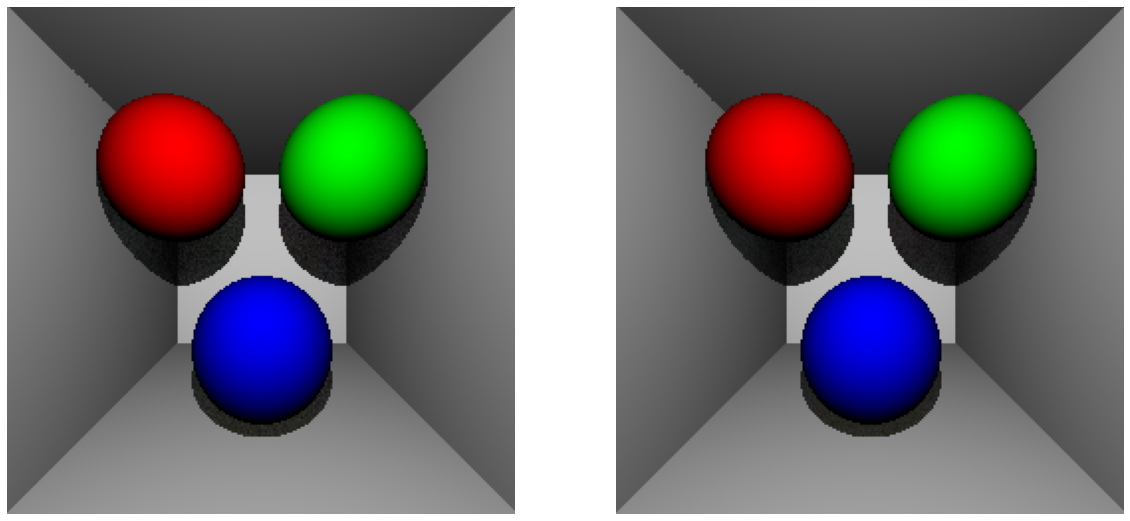

In [24]:
# create a scene
objs = [
    Plane(norm_axis='y', position=-50, color=array([.75,.75,.75],dtype=float)), # floor
    Plane(norm_axis='y', position=50,  color=array([.75,.75,.75],dtype=float)), # ceiling
    Plane(norm_axis='x', position=50,  color=array([.75,.75,.75],dtype=float)), # right wall
    Plane(norm_axis='x', position=-50, color=array([.75,.75,.75],dtype=float)), # left wall
    Plane(norm_axis='z', position=150,  color=array([.75,.75,.75],dtype=float)), # back wall
    Ball(center=array([-25,25,75],dtype=float), radius=20, color=array([1,0,0],dtype=float)), # ball
    Ball(center=array([25,25,75],dtype=float),  radius=20, color=array([0,1,0],dtype=float)), # ball
    Ball(center=array([0,-25,75],dtype=float),  radius=20, color=array([0,0,1],dtype=float)), # ball
]
light = PointLight(position=array([0,25,0],dtype=float), intensity=1)
# parameters
n = 32
d = 4
px = 256
# render image
fig,ax = pyplot.subplots(ncols=2,nrows=1,figsize=(20,10))# render scene
# IID (MC)
scene = CustomScene(objs,light,n,d,mc_type='IID')
camera = Camera(ax[0], scene, px=px, parallel_x_blocks=8, parallel_y_blocks=8, image_angle=pi/2, image_dist=1)
camera.render()
# Sobol (QMC)
scene = CustomScene(objs,light,n,d,mc_type='SOBOL')
camera = Camera(ax[1], scene, px=px, parallel_x_blocks=8, parallel_y_blocks=8, image_angle=pi/2, image_dist=1)
camera.render()